## Basics


In [1]:
# imports
import numpy as np

import commstools.plotting as plotting
from commstools import set_backend, get_backend
from commstools.dsp.filtering import rrc_taps
from commstools.dsp.sequences import prbs
from commstools.waveforms import ook

set_backend("jax")
backend = get_backend()


Let's start with generating a bit sequence which will represent the data we want to transmit.

In [2]:
# Generate a Pseudo-Random Binary Sequence (PRBS)
bits = prbs(length=100000, order=31, seed=0x30F1CA55)

print("First Generated 20 bits:", bits[:20], "...")
print("Mean value: ", backend.mean(bits))


W1203 14:53:27.764749  350841 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1203 14:53:27.766937  350751 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


First Generated 20 bits: [1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0] ...
Mean value:  0.53332


Let's define base system parameters and map the bits to an OOK signal.

First 20 symbols of OOK signal with zeros inserted:


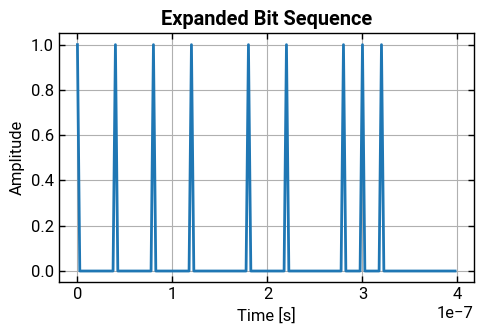

In [3]:
# Define system parameters
symbol_rate = 50e6
sampling_rate = 400e6
sps = int(sampling_rate / symbol_rate)
rrc_rolloff = 0.7

sig_impulse = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="none")

print("First 20 symbols of OOK signal with zeros inserted:")
sig_impulse.plot_signal(num_symbols=20, show=True, title="Expanded Bit Sequence")


Now, let's pulse shape the signal to get the actual waveform.

First 20 symbols of OOK signal with Boxcar pulse shaping:


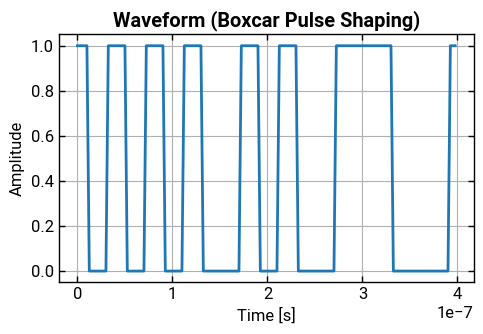

Its spectrum:


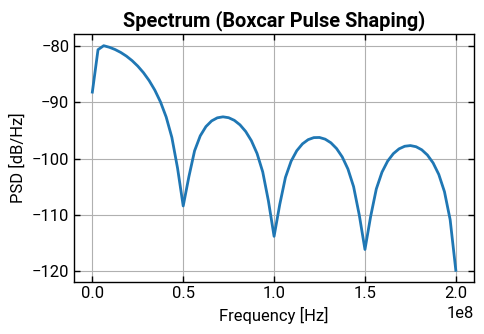

In [4]:
# Boxcar (rectangular) pulse shaping
sig_boxcar = ook(bits, sampling_rate=sampling_rate, sps=sps, pulse_shape="boxcar")
print("First 20 symbols of OOK signal with Boxcar pulse shaping:")
sig_boxcar.plot_signal(
    num_symbols=20, show=True, title="Waveform (Boxcar Pulse Shaping)"
)
print("Its spectrum:")
sig_boxcar.plot_psd(show=True, title="Spectrum (Boxcar Pulse Shaping)")


First 20 symbols of OOK signal with RRC pulse shaping:


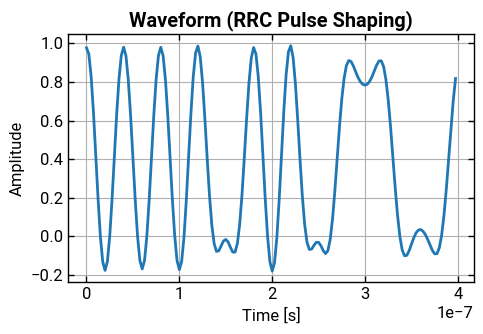

Its spectrum:


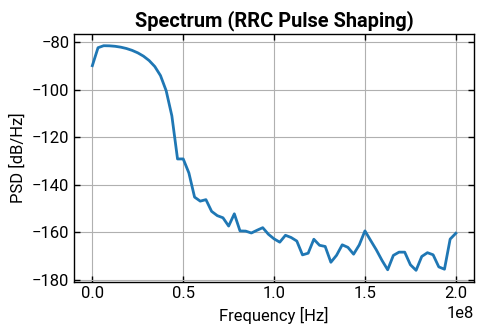

In [5]:
# RRC pulse shaping
sig_rrc = ook(
    bits,
    sampling_rate=sampling_rate,
    sps=sps,
    pulse_shape="rrc",
    filter_span=18,
    rrc_rolloff=rrc_rolloff,
)
print("First 20 symbols of OOK signal with RRC pulse shaping:")
sig_rrc.plot_signal(num_symbols=20, show=True, title="Waveform (RRC Pulse Shaping)")
print("Its spectrum:")
sig_rrc.plot_psd(show=True, title="Spectrum (RRC Pulse Shaping)")


Let's investigate the RRC filter we applied.

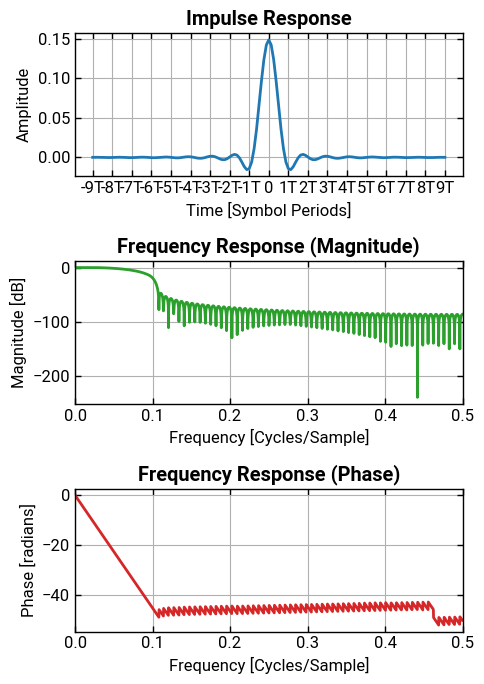

In [6]:
# Create the same RRC filter
rrc_filter = rrc_taps(sps=sps, rolloff=rrc_rolloff, span=18)

# Plot the filter response
plotting.filter_response(rrc_filter, sps, show=True)


Let's add some noise to the signal for naive representation of distorted signal on the receiver.

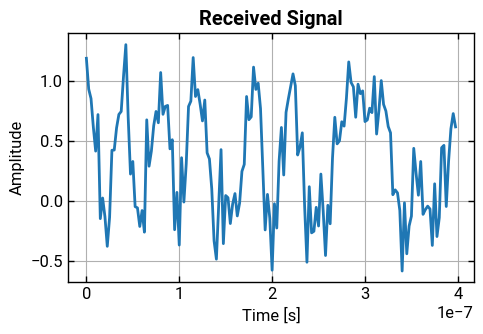

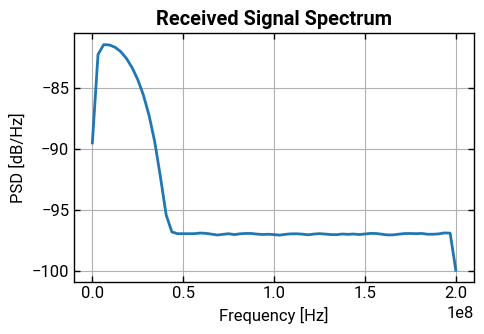

In [7]:
sig_received = sig_rrc.update(
    sig_rrc.samples + 0.2 * np.random.randn(*sig_rrc.samples.shape)
)

sig_received.plot_signal(num_symbols=20, show=True, title="Received Signal")
sig_received.plot_psd(show=True, title="Received Signal Spectrum")


Now we can check what happens on the receiver side.
As the pulse shape is RRC, we need to use a matched filter with the same RRC shape at the receiver.

First 20 symbols after matched filtering:


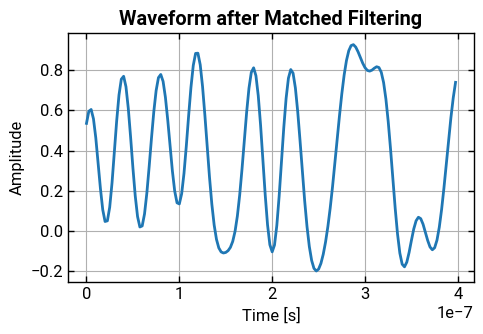

Its spectrum:


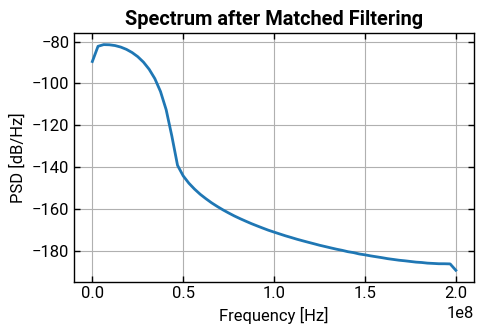

In [8]:
sig_matchedfilt = sig_received.matched_filter(
    pulse_taps=rrc_filter, taps_normalization="unity_gain", normalize_output=False
)

print("First 20 symbols after matched filtering:")
sig_matchedfilt.plot_signal(
    num_symbols=20, show=True, title="Waveform after Matched Filtering"
)

print("Its spectrum:")
sig_matchedfilt.plot_psd(show=True, title="Spectrum after Matched Filtering")


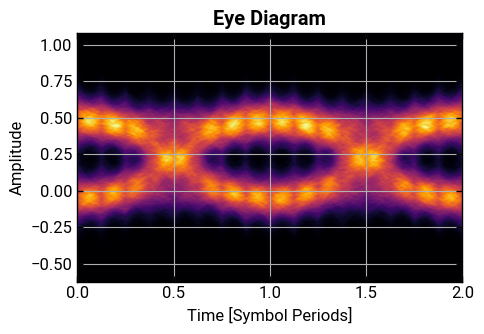

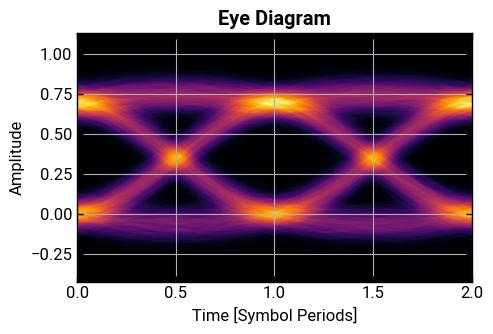

In [9]:
sig_received.plot_eye(plot_type="hist", show=True, cmap="inferno")
sig_matchedfilt.plot_eye(plot_type="hist", show=True, cmap="inferno")
